In [222]:
import psycopg2 # database connection
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # create plots
from scipy import stats # math
from IPython.display import display # display the final plot
from scipy.optimize import curve_fit
import config # fstore/access database credentials

In [223]:
# define the database connection, and map credentials to the config.py file
conn = psycopg2.connect(host=config.host, port=5432, dbname=config.db_name, user=config.db_user, password=config.db_pw)

In [224]:
# creates cursor class to execute PostgreSQL command
cur = conn.cursor()

In [225]:
# Get year, month, and average precip/temp for each month
# Set variable for SQL query
sql = """
SELECT
	EXTRACT(YEAR FROM datetime) AS year, 
	CASE EXTRACT(MONTH FROM datetime)
		WHEN 1 THEN 'January'
		WHEN 2 THEN 'February'
		WHEN 3 THEN 'March'
		WHEN 4 THEN 'April'
		WHEN 5 THEN 'May'
		WHEN 6 THEN 'June'
		WHEN 7 THEN 'July'
		WHEN 8 THEN 'August'
		WHEN 9 THEN 'September'
		WHEN 10 THEN 'October'
		WHEN 11 THEN 'November'
		WHEN 12 THEN 'December'
		END AS month,
	ROUND(SUM(precip),2) AS total_monthly_precip,
	ROUND(AVG(temp),2) AS avg_monthly_temp
FROM
	houston_historical
GROUP BY
	EXTRACT(YEAR FROM datetime),
	EXTRACT(MONTH FROM datetime)
ORDER BY
	year ASC
      """

In [226]:
cur.execute(sql)

In [227]:
query_results = cur.fetchall()

In [228]:
cur.close()
conn.close()

In [229]:
cols = []
for elt in cur.description:
    cols.append(elt[0])

In [230]:
df = pd.DataFrame(data=query_results,columns=cols)

In [231]:
print(df)

     year     month total_monthly_precip avg_monthly_temp
0    1973   January                 4.96            48.61
1    1973  February                 3.40            51.68
2    1973     March                 3.68            64.86
3    1973     April                 7.13            65.32
4    1973       May                 4.14            73.68
..    ...       ...                  ...              ...
599  2022  December                 1.57            58.10
600  2023   January                 1.77            60.06
601  2023  February                 0.38            61.13
602  2023     March                 0.60            67.41
603  2023     April                 2.11            69.40

[604 rows x 4 columns]


In [232]:
# Function to convert year and temp columns to numeric (float) data type from object data type
def convert_columns_to_numeric(dataframes, column_names):
    for df in dataframes:
        for column in column_names:
            if column in df.columns:
                df[column] = pd.to_numeric(df[column])
            else:
                print(f"Column '{column}' not found in dataframe.")

In [233]:
dataframes = [df] # list of dataframes
columns = ['year', 'total_monthly_precip', 'avg_monthly_temp'] # list of columns
convert_columns_to_numeric(dataframes, columns) # call function and pass through vars

In [234]:
print(df)

       year     month  total_monthly_precip  avg_monthly_temp
0    1973.0   January                  4.96             48.61
1    1973.0  February                  3.40             51.68
2    1973.0     March                  3.68             64.86
3    1973.0     April                  7.13             65.32
4    1973.0       May                  4.14             73.68
..      ...       ...                   ...               ...
599  2022.0  December                  1.57             58.10
600  2023.0   January                  1.77             60.06
601  2023.0  February                  0.38             61.13
602  2023.0     March                  0.60             67.41
603  2023.0     April                  2.11             69.40

[604 rows x 4 columns]


In [235]:
df.dtypes

year                    float64
month                    object
total_monthly_precip    float64
avg_monthly_temp        float64
dtype: object

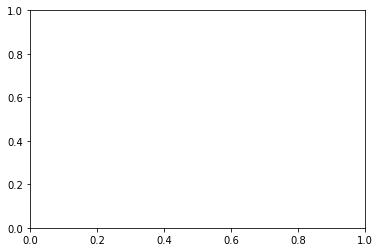

In [236]:
# define figure and axes objects 
fig, ax = plt.subplots()

In [237]:
# define scatter plot and attributes
ax.scatter(df['avg_monthly_temp'], df['total_monthly_precip'], marker = '.', label='Temp vs. Rainfall', color='#3378b6')

In [238]:
# Non-linear curve fitting
def func(x, a, b, c):
    return a * x**2 + b * x + c

popt, pcov = curve_fit(func, df['avg_monthly_temp'], df['total_monthly_precip'])

# Generate curve line
curve_line = func(df['avg_monthly_temp'], *popt)

# Plot the non-linear curve line
ax.plot(df['avg_monthly_temp'], curve_line, color='r')

In [ ]:
# create trend line (line of best fit) for avg summer temps
slope, intercept, r_value, p_value, std_err = stats.linregress(df['avg_monthly_temp'], df['total_monthly_precip'])
trend_line = intercept + slope * df['avg_monthly_temp']

In [239]:
# plot summer temps trend line
ax.plot(df['avg_monthly_temp'], trend_line, color='r')

In [240]:
# Set labels
ax.set_xlabel('Average Temperature (Fahrenheit)')
ax.set_ylabel('Total Precipitation (Inches)')
ax.set_title('Temperature vs. Precipitation - Houston, TX 1973-2023')

Text(0.5, 1.0, 'Temperature vs. Precipitation - Houston, TX 1973-2023')

In [241]:
# enable legend
ax.legend()

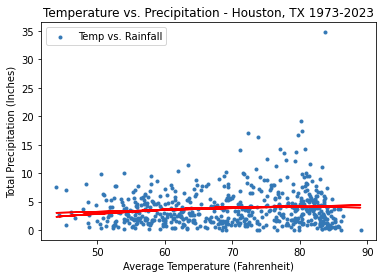

In [242]:
# show final plot
display(fig)

In [243]:
# Linear regression for avg_summer_temps dataframe
results = stats.linregress(df['avg_monthly_temp'], df['total_monthly_precip'])
print(results)

LinregressResult(slope=0.03019057154183148, intercept=1.7181799110327525, rvalue=0.10216126026950846, pvalue=0.012000425471475843, stderr=0.011981428172120225, intercept_stderr=0.8442631975169884)


In [247]:
results2 = stats.normaltest(df['avg_monthly_temp'])

In [248]:
print(results2)

NormaltestResult(statistic=407.86575123651613, pvalue=2.7106749372323235e-89)
